In [4]:
%matplotlib inline
import cvxpy as cp
import numpy as np
import pandas as pd
import pathos.pools
import time
import copy
import pkg_resources

import matplotlib.pyplot as plt
import matplotlib.animation as animation

from simglucose.controller.base import Controller, Action
from simglucose.patient.t1dpatient import T1DPatient
from simglucose.simulation.sim_engine import SimObj
from simglucose.sensor.cgm import CGMSensor, CGMNoise
from simglucose.actuator.pump import InsulinPump
from simglucose.simulation.scenario import CustomScenario
from simglucose.simulation.env import T1DSimEnv
from datetime import timedelta, datetime
from analysis import single_pt_ts


PATIENT_PARA_FILE = pkg_resources.resource_filename(
    'simglucose', 'params/vpatient_params.csv')
CONTROL_QUEST = pkg_resources.resource_filename(
    'simglucose', 'params/Quest.csv')

In [5]:
class MPC(Controller):
    def __init__(self, patientname, target, low, horizon):
        self.target = target
        self.low = low
        self.horizon = horizon
        self.params = pd.read_csv(PATIENT_PARA_FILE)
        self.quest = pd.read_csv(CONTROL_QUEST)
        self.action_count = 0

        # patient lookups
        if any(self.params.Name.str.match(patientname)):
            self.basal = self.params[self.params.Name.str.match(patientname)].BW.values / 6000
        else:
            raise LookupError("Invalid patient name. No patient by that name found in PARA file.")
        if any(self.quest.Name.str.match(patientname)):
            self.TDI = self.quest[self.quest.Name.str.match(patientname)].TDI.values
        else:
            raise LookupError("Invalid patient name. No patient by that name found in QUEST file.")

        # scalar constants
        self.p1 = 0.98
        self.p2 = 0.965
        self.g = -90 * (1-self.p1)*(1-self.p2)*(1-self.p2)

        # Open loop behavior R3x3
        self.A = np.array([   
                [self.p1+2*self.p2, -2*self.p1*self.p2-self.p2*self.p2, self.p1*self.p2*self.p2],
                [1,0,0],
                [0,1,0]])
        # Actuator effect
        self.B = 1800 * self.g / self.TDI * np.array([[1],[0],[0]])
        # CGM stored here
        self.cgm = np.array([0,0,0])

    def policy(self, observation, reward, done, plot=True, **info):
        self.cgm[2] = self.cgm[1]
        self.cgm[1] = self.cgm[0]
        self.cgm[0] = observation.CGM
        bolus_multiplier = info['sample_time'] / 60

        if self.action_count > 4:
            print("\tAction {}".format(str(self.action_count).rjust(5)))
            s = cp.Variable((3, self.horizon+1))
            u = cp.Variable((1, self.horizon))
            cost = 0
            constr = []
            constr += [s[:,0] == self.cgm]
            for t in range(self.horizon):
                cost += cp.sum_squares(s[:,t] - self.target) + cp.sum_squares(u[:,t])
                constr += [
                    s[:,t + 1] == self.A @ s[:,t] + self.B @ u[:,t] * bolus_multiplier,
                    u[:,t] >= 0,
                ]
            
            problem = cp.Problem(cp.Minimize(cost), constr)
            problem.solve(verbose=False, solver='SCS')
            print("\tStatus: {}".format(problem.status))
            self.bolus = u.value[0,0] * bolus_multiplier
            print("\tOptimal bolus action is {}".format(self.bolus))
            action = Action(basal=self.basal, bolus=self.bolus)
            
            if plot:
                fig = plt.figure()
                ax = fig.add_subplot(211)
                plt.plot(range(s[0,:].size), s[0,:].value, label='state')
                plt.subplot(2,1,2)
                plt.step(range(u[0,:].size), u[0,:].value * bolus_multiplier, label='control')
                plt.show()
            
        else:
            action = Action(basal=self.basal, bolus=0)
        self.action_count += 1
        return action

        def reset(self):
            pass

Simulating...
	Action     5
	Status: optimal_inaccurate
	Optimal bolus action is 0.009996647203322143


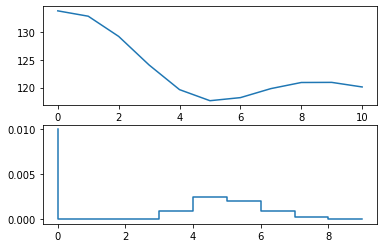

	Action     6
	Status: optimal_inaccurate
	Optimal bolus action is 0.008471370702330424


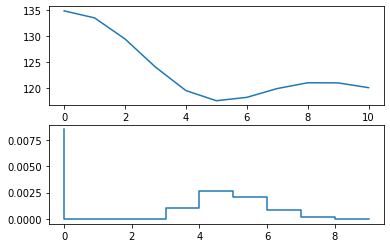

	Action     7
	Status: optimal_inaccurate
	Optimal bolus action is 0.009234743626787193


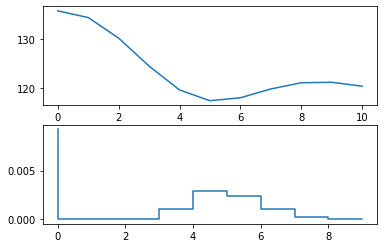

	Action     8
	Status: optimal_inaccurate
	Optimal bolus action is 0.015440121205193391


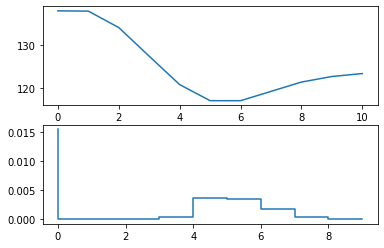

	Action     9
	Status: optimal_inaccurate
	Optimal bolus action is 0.009286052579657594


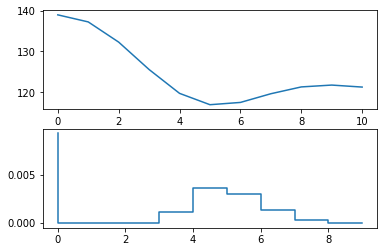

	Action    10
	Status: optimal_inaccurate
	Optimal bolus action is 0.01251234267845044


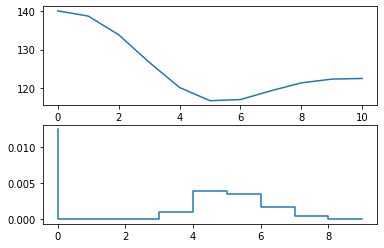

	Action    11
	Status: optimal_inaccurate
	Optimal bolus action is 0.01925539924272317


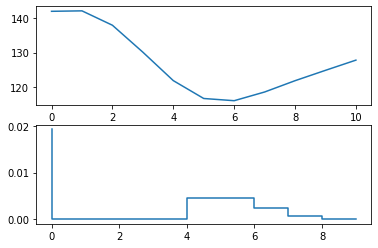

	Action    12
	Status: optimal_inaccurate
	Optimal bolus action is 0.007781377530026787


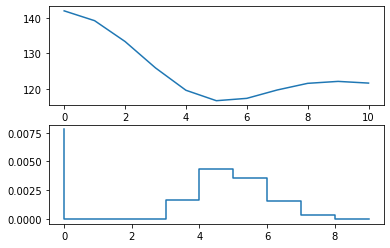

	Action    13
	Status: optimal_inaccurate
	Optimal bolus action is 0.018098046095636897


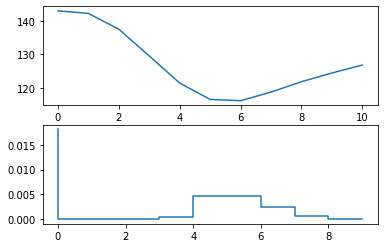

	Action    14
	Status: optimal_inaccurate
	Optimal bolus action is 0.010829182186712877


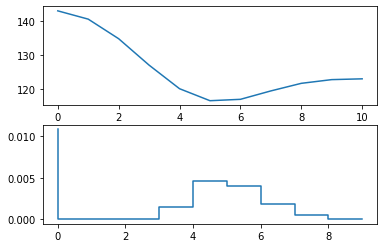

	Action    15
	Status: optimal_inaccurate
	Optimal bolus action is 0.008528187831063013


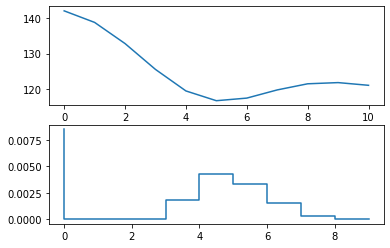

	Action    16
	Status: optimal_inaccurate
	Optimal bolus action is 0.015164755728410032


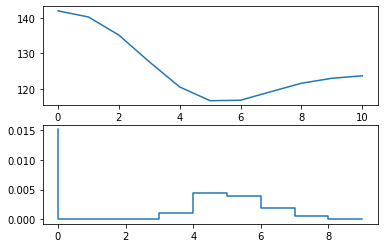

	Action    17
	Status: optimal_inaccurate
	Optimal bolus action is 0.007802108384807026


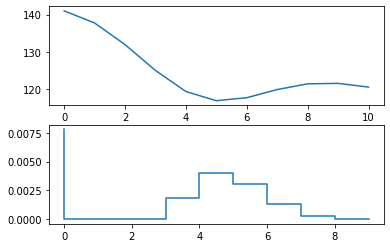

	Action    18
	Status: optimal_inaccurate
	Optimal bolus action is 0.009244862692179986


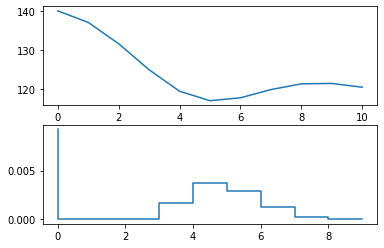

	Action    19
	Status: optimal_inaccurate
	Optimal bolus action is 0.01333597191336525


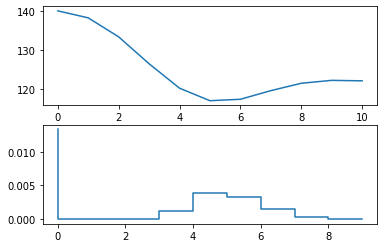

	Action    20
	Status: optimal_inaccurate
	Optimal bolus action is 0.016178296371228827


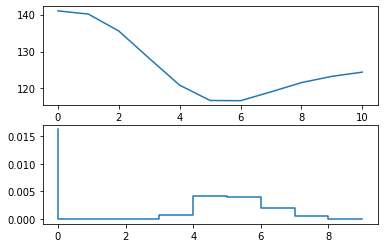

	Action    21
	Status: optimal_inaccurate
	Optimal bolus action is 0.009268228919437132


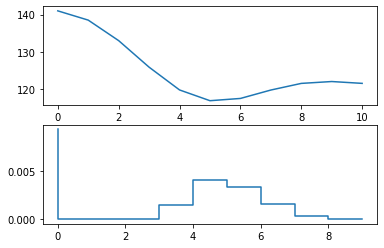

	Action    22
	Status: optimal_inaccurate
	Optimal bolus action is 0.01713190237368088


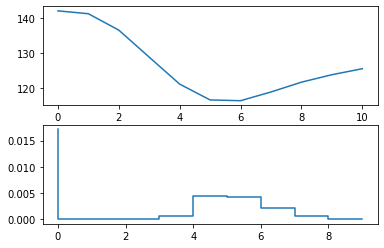

	Action    23
	Status: optimal_inaccurate
	Optimal bolus action is 0.015164235878946348


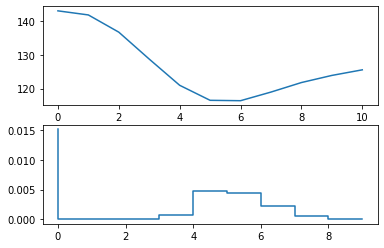

	Action    24
	Status: optimal_inaccurate
	Optimal bolus action is 0.016077002583508193


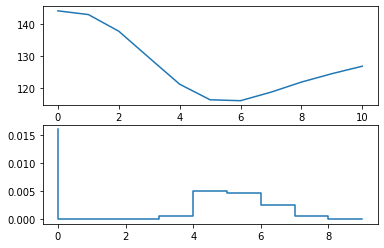

	Action    25
	Status: optimal_inaccurate
	Optimal bolus action is 0.011637357217485145


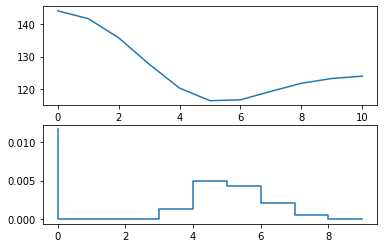

	Action    26
	Status: optimal_inaccurate
	Optimal bolus action is 0.02006123041704046


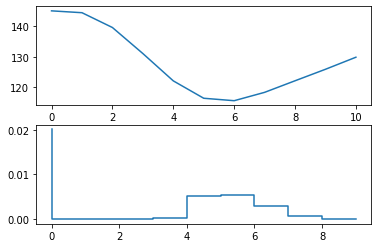

	Action    27
	Status: optimal_inaccurate
	Optimal bolus action is 0.012462178233598844


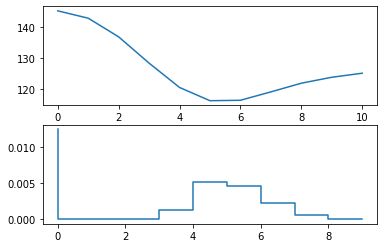

	Action    28
	Status: optimal_inaccurate
	Optimal bolus action is 0.021055017691816027


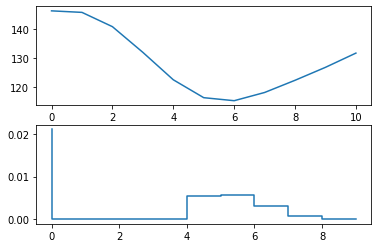

	Action    29
	Status: optimal_inaccurate
	Optimal bolus action is 0.025258841879197802


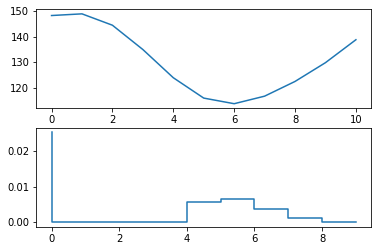

	Action    30
	Status: optimal_inaccurate
	Optimal bolus action is 0.01774313811694454


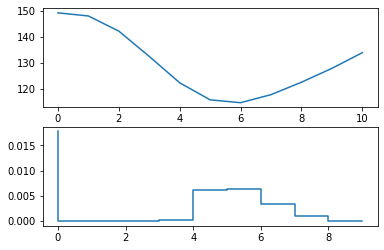

	Action    31
	Status: optimal_inaccurate
	Optimal bolus action is 0.03558938112678241


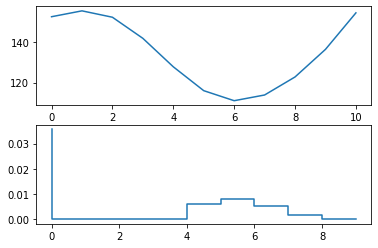

	Action    32
	Status: optimal_inaccurate
	Optimal bolus action is 0.024332567726849257


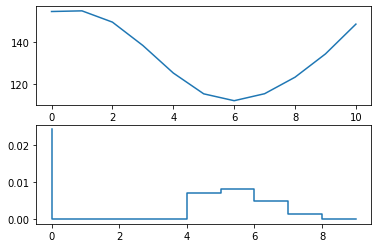

	Action    33
	Status: optimal_inaccurate
	Optimal bolus action is 0.04440655896412393


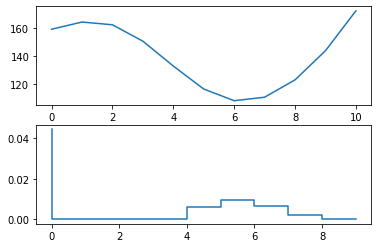

	Action    34
	Status: optimal_inaccurate
	Optimal bolus action is 0.04014185956136826


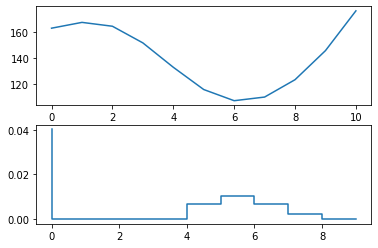

	Action    35
	Status: optimal_inaccurate
	Optimal bolus action is 0.04419087611155703


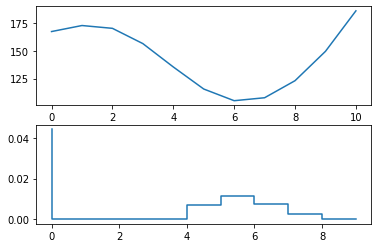

	Action    36
	Status: optimal_inaccurate
	Optimal bolus action is 0.05623239845666217


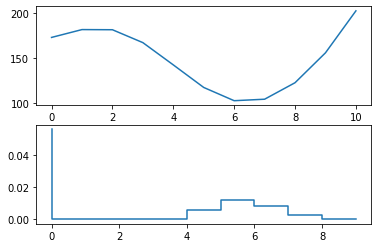

	Action    37
	Status: optimal_inaccurate
	Optimal bolus action is 0.05698887135474903


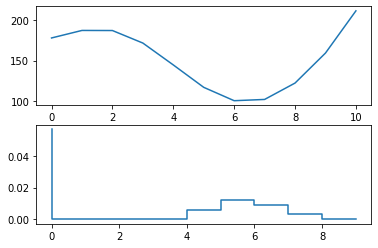

	Action    38
	Status: optimal_inaccurate
	Optimal bolus action is 0.062347697244242134


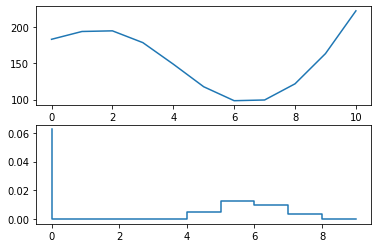

	Action    39
	Status: optimal_inaccurate
	Optimal bolus action is 0.07662022004956227


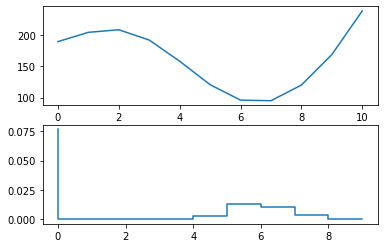

	Action    40
	Status: optimal_inaccurate
	Optimal bolus action is 0.0783004746471185


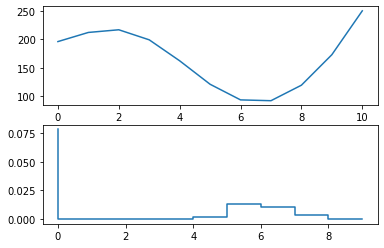

	Action    41
	Status: optimal_inaccurate
	Optimal bolus action is 0.08522669722171859


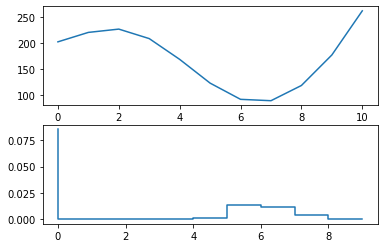

	Action    42
	Status: optimal_inaccurate
	Optimal bolus action is 0.09229931048222136


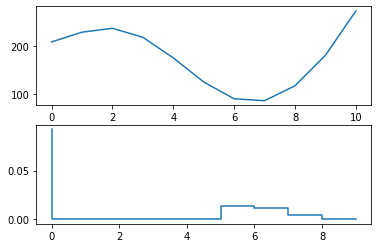

	Action    43
	Status: optimal_inaccurate
	Optimal bolus action is 0.08987419030012495


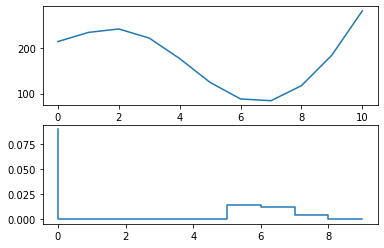

	Action    44
	Status: optimal_inaccurate
	Optimal bolus action is 0.11172073858821835


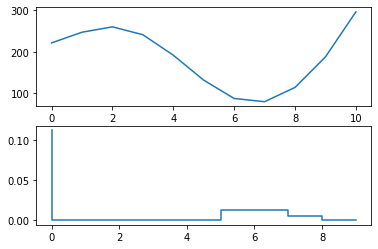

	Action    45
	Status: optimal_inaccurate
	Optimal bolus action is 0.10290105079644406


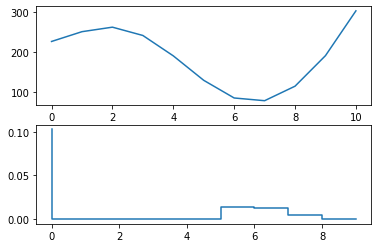

	Action    46
	Status: optimal_inaccurate
	Optimal bolus action is 0.11506752807810045


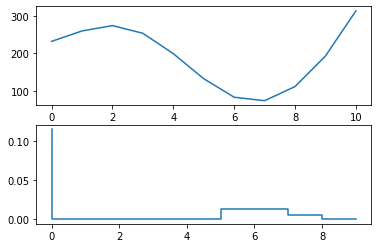

	Action    47
	Status: optimal_inaccurate
	Optimal bolus action is 0.11086659138673156


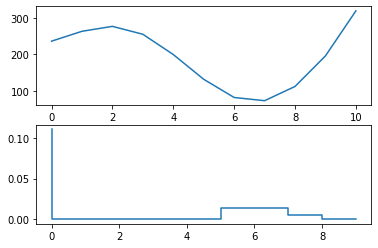

	Action    48
	Status: optimal_inaccurate
	Optimal bolus action is 0.12207926394557421


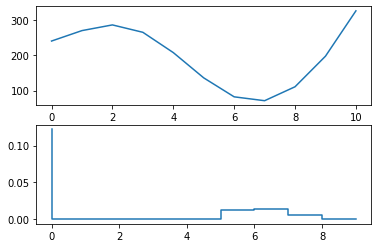

	Action    49
	Status: optimal_inaccurate
	Optimal bolus action is 0.08727376222976872


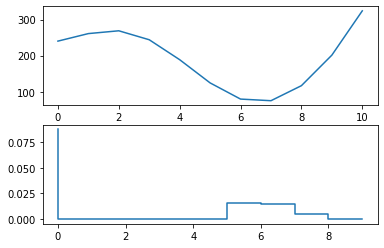

	Action    50
	Status: optimal_inaccurate
	Optimal bolus action is 0.0643243979257887


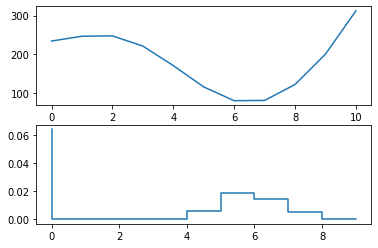

	Action    51
	Status: optimal_inaccurate
	Optimal bolus action is 0.11356294564138164


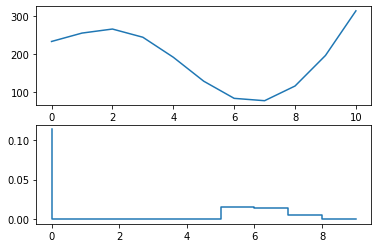

	Action    52
	Status: optimal_inaccurate
	Optimal bolus action is 0.10314338395266337


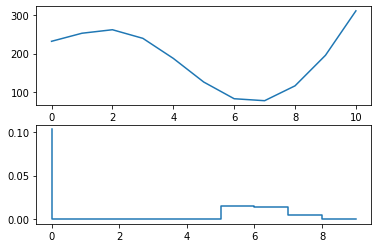

	Action    53
	Status: optimal_inaccurate
	Optimal bolus action is 0.11648888078795955


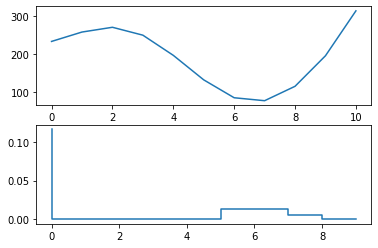

	Action    54
	Status: optimal_inaccurate
	Optimal bolus action is 0.11582092976056767


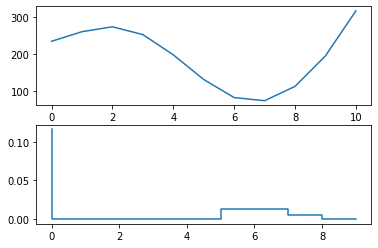

	Action    55
	Status: optimal_inaccurate
	Optimal bolus action is 0.11213428511289077


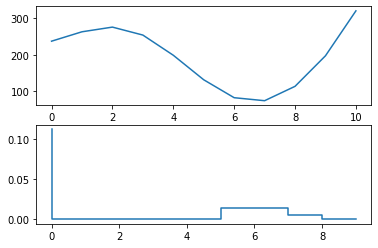

	Action    56
	Status: optimal_inaccurate
	Optimal bolus action is 0.1146093023112605


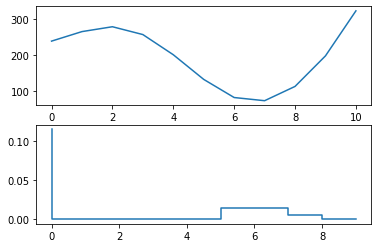

	Action    57
	Status: optimal_inaccurate
	Optimal bolus action is 0.11709883926570852


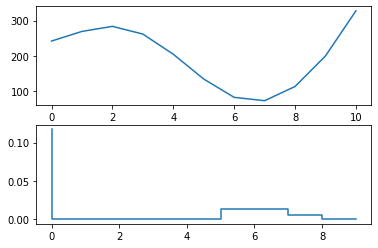

	Action    58
	Status: optimal_inaccurate
	Optimal bolus action is 0.09932826273717035


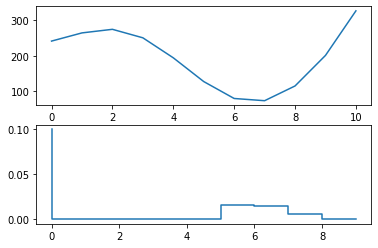

	Action    59
	Status: optimal_inaccurate
	Optimal bolus action is 0.10103174136010491


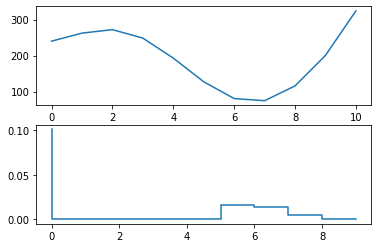

	Action    60
	Status: optimal_inaccurate
	Optimal bolus action is 0.09590428791728818


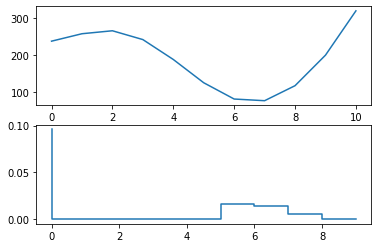

	Action    61
	Status: optimal_inaccurate
	Optimal bolus action is 0.08975486867860342


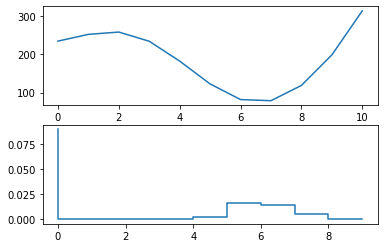

	Action    62
	Status: optimal_inaccurate
	Optimal bolus action is 0.08264694067405007


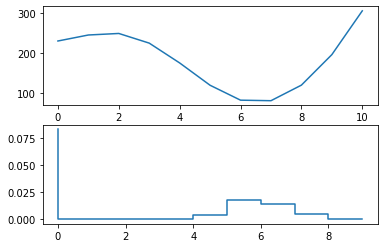

	Action    63
	Status: optimal_inaccurate
	Optimal bolus action is 0.09274078453712176


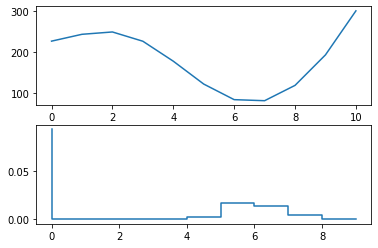

	Action    64
	Status: optimal_inaccurate
	Optimal bolus action is 0.08388092806727612


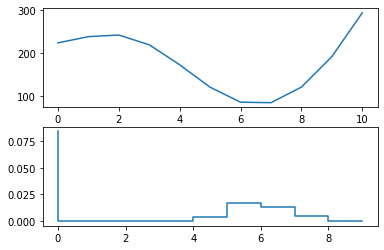

	Action    65
	Status: optimal_inaccurate
	Optimal bolus action is 0.09930561091964203


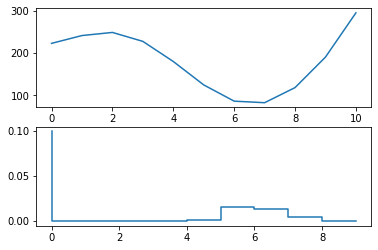

	Action    66
	Status: optimal_inaccurate
	Optimal bolus action is 0.09640508313214312


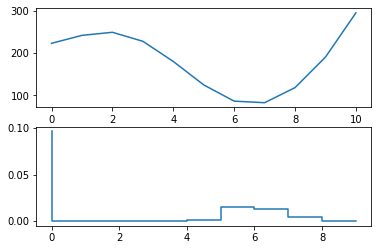

	Action    67
	Status: optimal_inaccurate
	Optimal bolus action is 0.0908237028260519


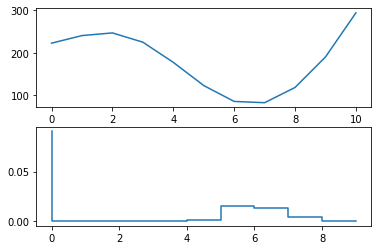

	Action    68
	Status: optimal_inaccurate
	Optimal bolus action is 0.0908237028260519


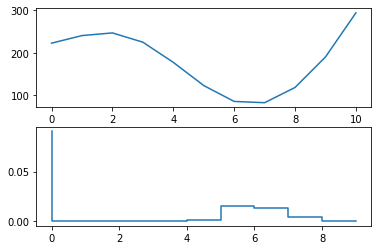

	Action    69
	Status: optimal_inaccurate
	Optimal bolus action is 0.08167709070655518


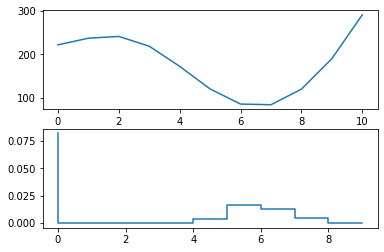

	Action    70
	Status: optimal_inaccurate
	Optimal bolus action is 0.08581287029896395


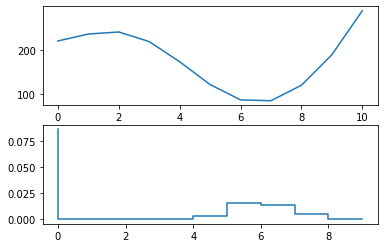

	Action    71
	Status: optimal_inaccurate
	Optimal bolus action is 0.07579703529848597


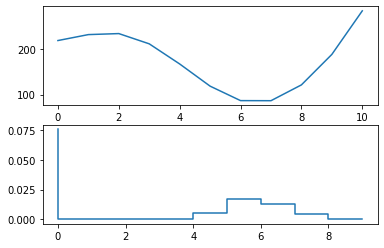

	Action    72
	Status: optimal_inaccurate
	Optimal bolus action is 0.07005533493246228


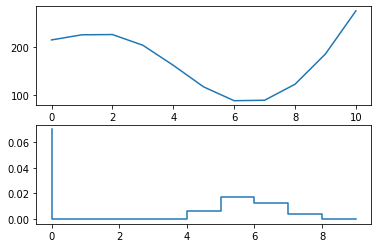

	Action    73
	Status: optimal_inaccurate
	Optimal bolus action is 0.07173385767312673


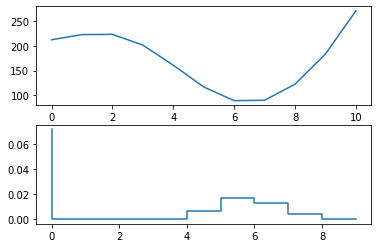

	Action    74
	Status: optimal_inaccurate
	Optimal bolus action is 0.05247653119717186


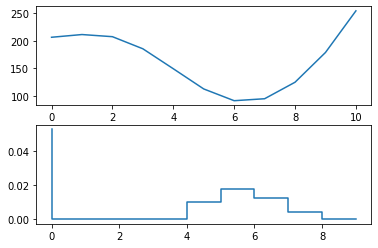

	Action    75
	Status: optimal_inaccurate
	Optimal bolus action is 0.06439467351061025


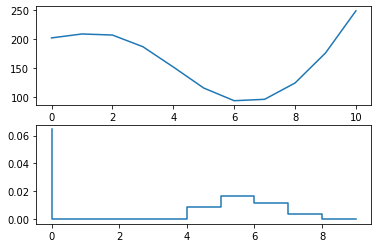

	Action    76
	Status: optimal_inaccurate
	Optimal bolus action is 0.047943923172024665


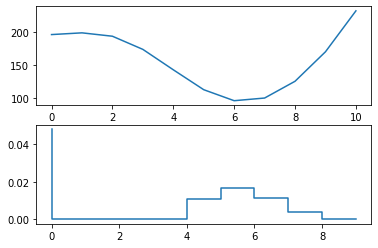

	Action    77
	Status: optimal_inaccurate
	Optimal bolus action is 0.05485625024484517


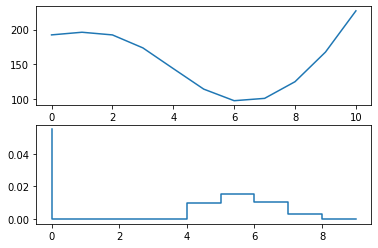

	Action    78
	Status: optimal_inaccurate
	Optimal bolus action is 0.04644338496985166


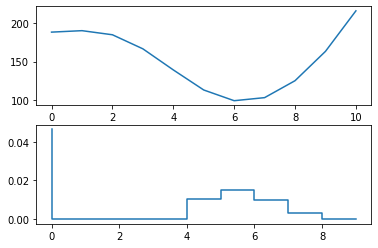

	Action    79
	Status: optimal_inaccurate
	Optimal bolus action is 0.057704791893449195


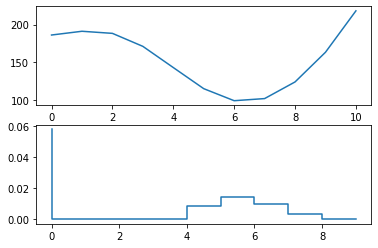

	Action    80
	Status: optimal_inaccurate
	Optimal bolus action is 0.06258010565187709


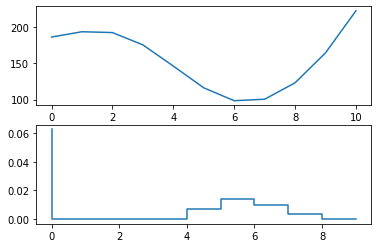

	Action    81
	Status: optimal_inaccurate
	Optimal bolus action is 0.053448869880922116


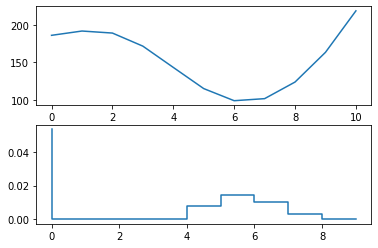

	Action    82
	Status: optimal_inaccurate
	Optimal bolus action is 0.053448869880922116


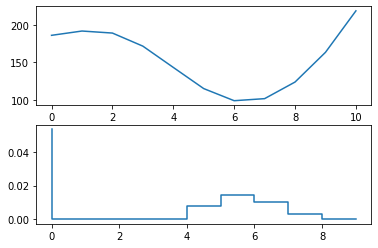

	Action    83
	Status: optimal_inaccurate
	Optimal bolus action is 0.06142361125378298


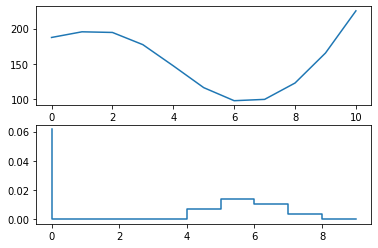

	Action    84
	Status: optimal_inaccurate
	Optimal bolus action is 0.05789990146379806


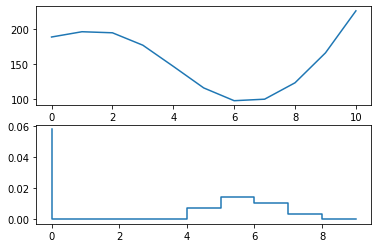

	Action    85
	Status: optimal_inaccurate
	Optimal bolus action is 0.04380599785071423


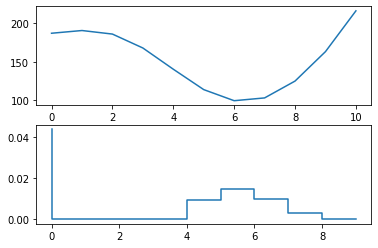

	Action    86
	Status: optimal_inaccurate
	Optimal bolus action is 0.05114623177755398


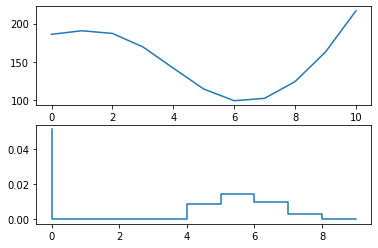

	Action    87
	Status: optimal_inaccurate
	Optimal bolus action is 0.05012002333851573


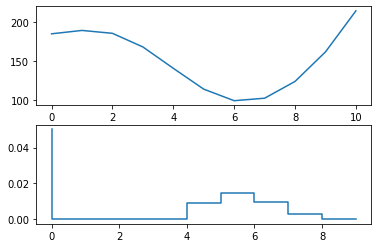

	Action    88
	Status: optimal_inaccurate
	Optimal bolus action is 0.0348443963873743


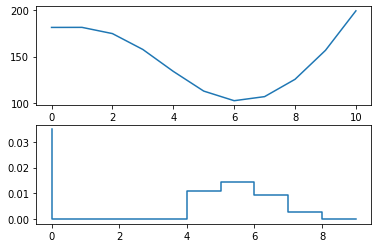

	Action    89
	Status: optimal_inaccurate
	Optimal bolus action is 0.03969806569294424


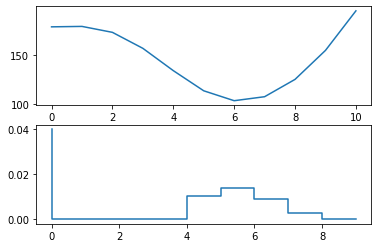

	Action    90
	Status: optimal_inaccurate
	Optimal bolus action is 0.03005043545717341


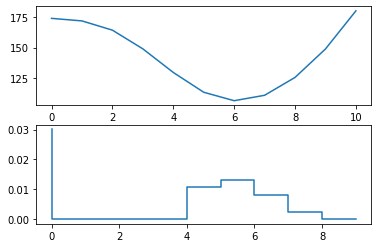

	Action    91
	Status: optimal_inaccurate
	Optimal bolus action is 0.02991703970605379


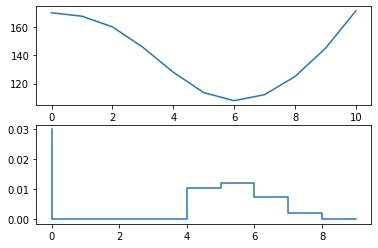

	Action    92
	Status: optimal_inaccurate
	Optimal bolus action is 0.02002698752288145


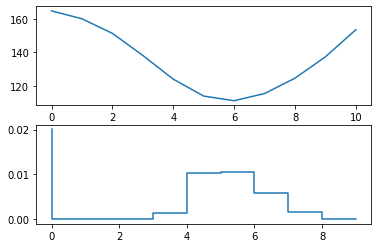

	Action    93
	Status: optimal_inaccurate
	Optimal bolus action is 0.02480381098641667


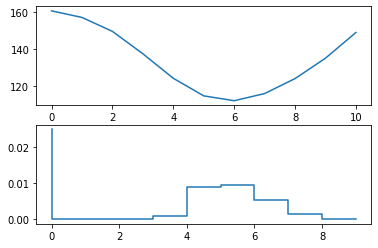

	Action    94
	Status: optimal_inaccurate
	Optimal bolus action is 0.017862428209893765


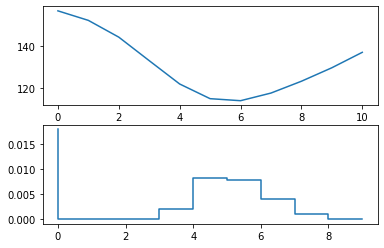

	Action    95
	Status: optimal_inaccurate
	Optimal bolus action is 0.01432491673267543


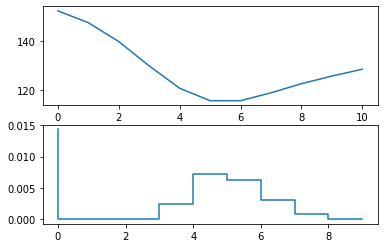

	Action    96
	Status: optimal_inaccurate
	Optimal bolus action is 0.02214906267208991


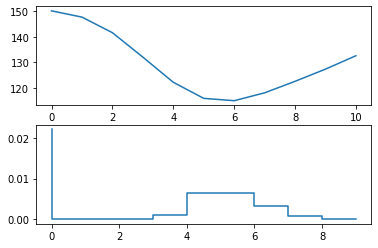

	Action    97
	Status: optimal_inaccurate
	Optimal bolus action is 0.014261744562691801


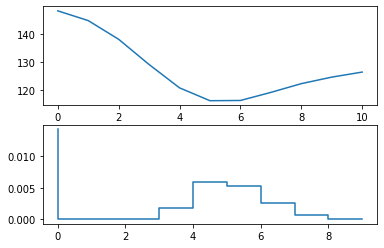

	Action    98
	Status: optimal_inaccurate
	Optimal bolus action is 0.024309573080805127


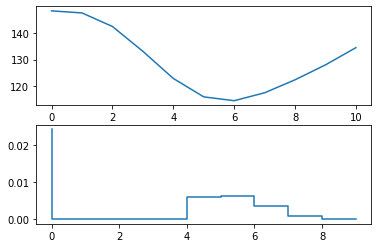

	Action    99
	Status: optimal_inaccurate
	Optimal bolus action is 0.007711232759150144


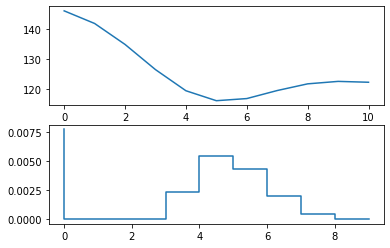

	Action   100
	Status: optimal_inaccurate
	Optimal bolus action is -2.7145441187170156e-05


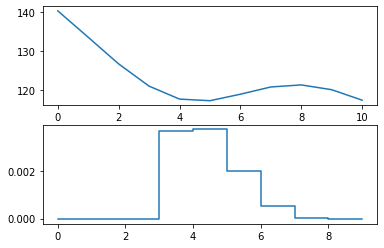

	Action   101
	Status: optimal_inaccurate
	Optimal bolus action is 0.0030388774539506776


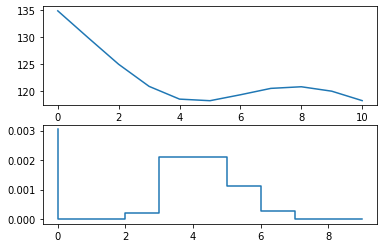

	Action   102
	Status: optimal_inaccurate
	Optimal bolus action is 0.002041795679660849


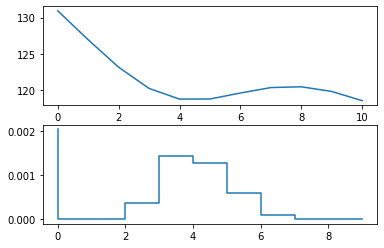

	Action   103
	Status: optimal_inaccurate
	Optimal bolus action is 0.0015695304649650408


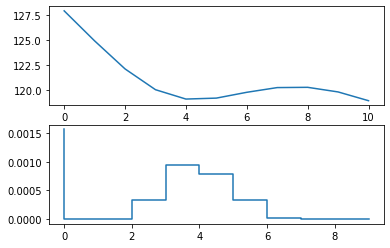

	Action   104
	Status: optimal_inaccurate
	Optimal bolus action is -4.900907642684904e-06


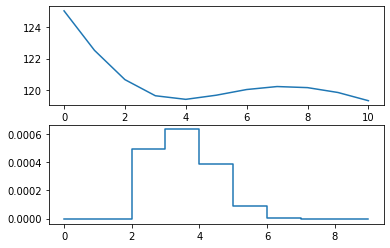

	Action   105
	Status: optimal_inaccurate
	Optimal bolus action is 0.0005159215678570359


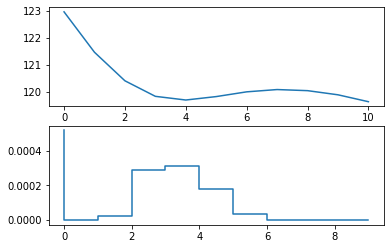

	Action   106
	Status: optimal_inaccurate
	Optimal bolus action is -1.9426733454946544e-05


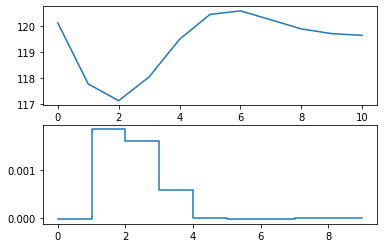

	Action   107
	Status: optimal_inaccurate
	Optimal bolus action is -4.1004988161583425e-06


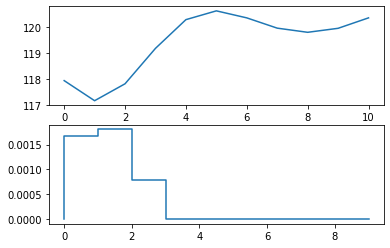

	Action   108
	Status: optimal_inaccurate
	Optimal bolus action is -1.379466874038977e-05


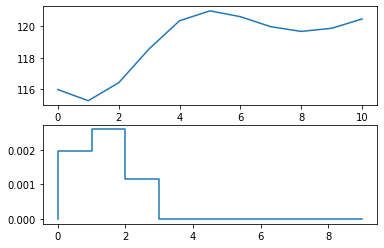

	Action   109
	Status: optimal_inaccurate
	Optimal bolus action is -1.7065286587218963e-05


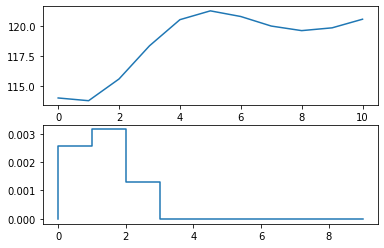

	Action   110
	Status: optimal_inaccurate
	Optimal bolus action is -2.9389092230306813e-05


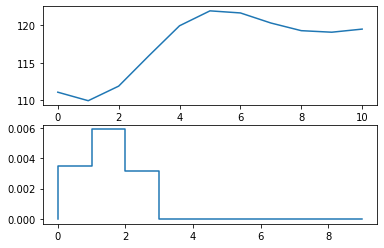

	Action   111
	Status: optimal_inaccurate
	Optimal bolus action is -2.623492154581633e-05


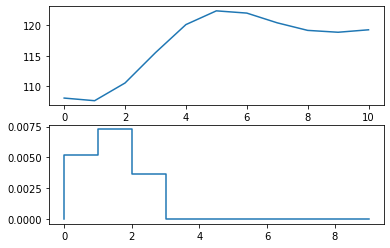

	Action   112
	Status: optimal_inaccurate
	Optimal bolus action is -1.87750062384229e-05


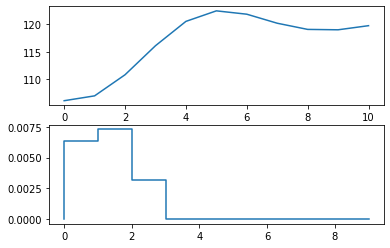

	Action   113
	Status: optimal_inaccurate
	Optimal bolus action is -3.457396075711188e-05


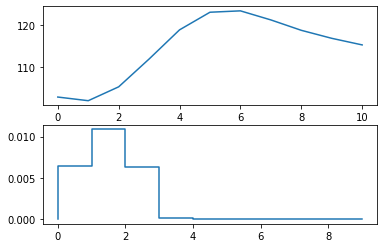

	Action   114
	Status: optimal_inaccurate
	Optimal bolus action is -1.1785242052854455e-05


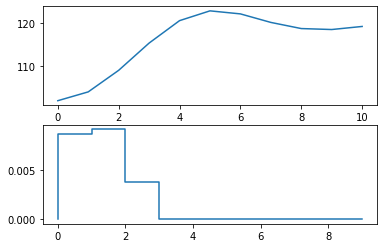

	Action   115
	Status: optimal_inaccurate
	Optimal bolus action is -2.515095917102963e-05


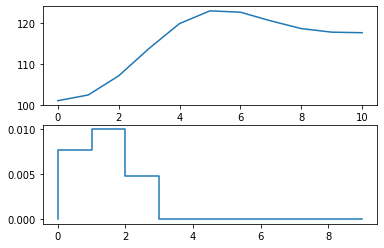

	Action   116
	Status: optimal_inaccurate
	Optimal bolus action is -2.5539809374480537e-05


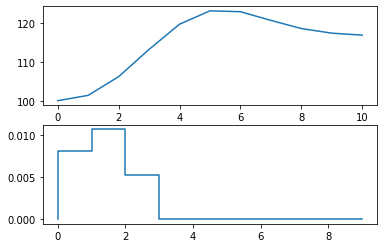

	Action   117
	Status: optimal_inaccurate
	Optimal bolus action is -1.6475182243534453e-05


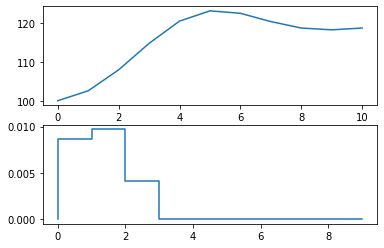

	Action   118
	Status: optimal_inaccurate
	Optimal bolus action is -3.1733706488566226e-05


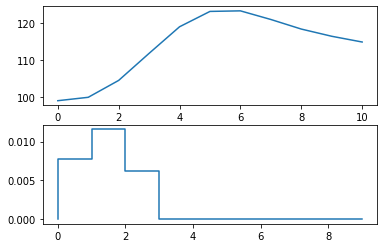

	Action   119
	Status: optimal_inaccurate
	Optimal bolus action is -3.398196606361742e-05


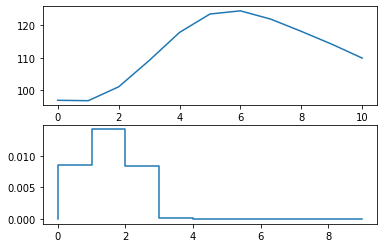

Simulation took 47.97919726371765 seconds.


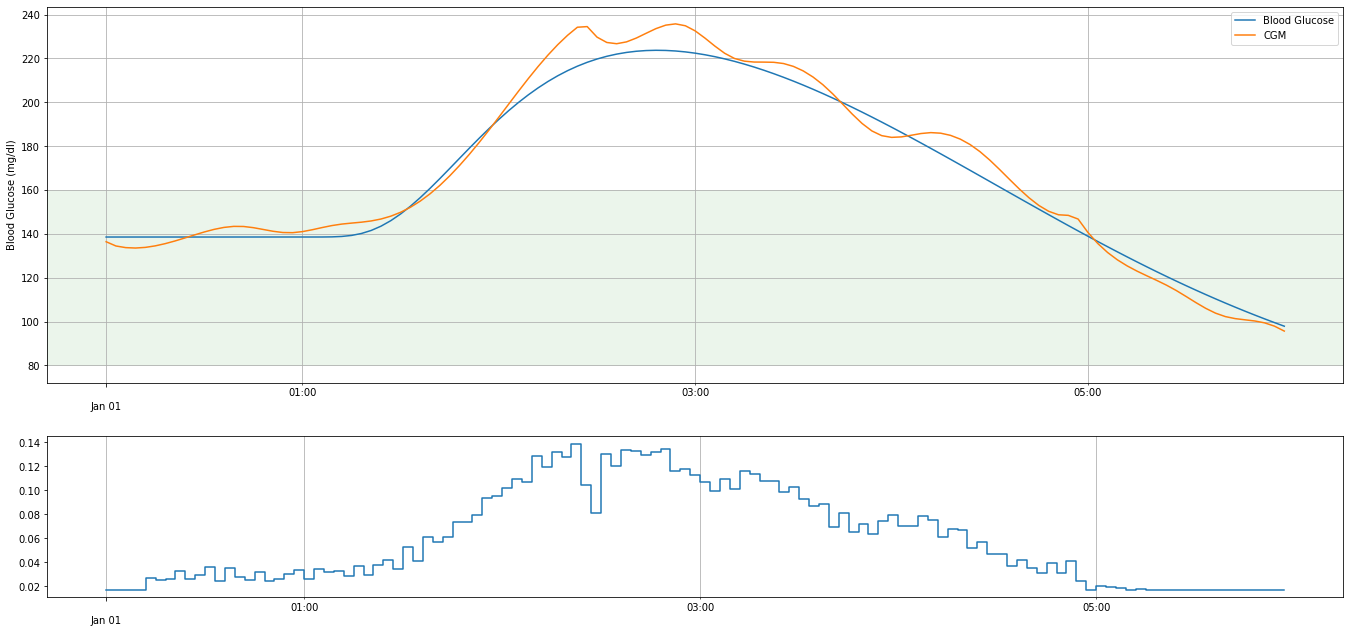

In [6]:
def sim(sim_object):
    print('Simulating...')
    sim_object.simulate()
    return sim_object.results()

if __name__ == '__main__':
    start_time = datetime(2020, 1,1,0,0,0)

    # sim env
    pname = 'adult#001'
    patient = T1DPatient.withName(pname)
    sensor = CGMSensor.withName('Dexcom', seed=92612)
    pump = InsulinPump.withName('Insulet')
    meals = [(1,45)]
    scenario = CustomScenario(start_time=start_time, scenario=meals)
    env = T1DSimEnv(patient, sensor, pump, scenario)
    controller = MPC(pname, 120, 80, 10)
    s1 = SimObj(env, controller, timedelta(hours=6), animate=False)
    p_start = time.time()
    results = sim(s1)
    print('Simulation took {} seconds.'.format(time.time() - p_start))

    fig = single_pt_ts(results)
    plt.show()